### Information theory and nudge impact

This notebook has as purpose to research the relation between information theoretical measures 
(mostly mutual information) and nudge impact of different nudges.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import collections

import numpy as np
from scipy.stats import entropy

from jointpdf.jointpdf import JointProbabilityMatrix
from jointpdf.jointpdf import NestedArrayOfProbabilities
from jointpdf.jointpdf import FullNestedArrayOfProbabilities
from extension_probability_matrix import JointProbabilityMatrixExtended

import probability_distributions
from probability_distributions import ProbabilityArray
import nudge
import plotting
import simulate
from information_theory import calculate_mutual_information
import information_theory


In [3]:
def calculate_amount_and_size_nudges(total_nudge_size, number_of_states, threshold=10):
    """
    Calculate the nudge size and the number of nudges that need to be performed 
    to nudge a variable with the total nudge size. Assuming the distribution is
    not too peaked, in other words, not too many states should have a probability
    that is 10 times smaller than normal.
    
    Parameters:
    ----------
    total_nudge_size: a number
        How much the variable need to be nudged
    number_of_states: a number
        The total number of states of the joint distribution
    threshold: a float 
        Indicating how much smaller than uniform the value of the number
        at the 95-99 percentile of points is. Defaults to 10 
        
    Returns: local_nudge, number_of_nudges
    -------
    local_nudge: a number 
        The size of the local nudge to be performed on the joint distribution
    number_of_nudges: integer
        How often the nudge need to be performed
    
    """
    assumed_min_size = 1.0/threshold
    max_local_nudge = min(total_nudge_size, 0.1/number_of_states)
    number_of_nudges = int(np.ceil(total_nudge_size/max_local_nudge))
    local_nudge = total_nudge_size/float(number_of_nudges) 
    return local_nudge, number_of_nudges

def generate_distribution(shape, method, arguments=None):
    if method=='random_biased':
        distribution = np.random.random(shape)
        distribution = distribution/np.sum(distribution)
        return distribution
    elif method=='random_dirichlet':
        return probability_distributions.compute_joint_uniform_random(shape)
    elif method=='fixed_entropy':
        return probability_distributions.generate_probability_distribution_with_certain_entropy(
            shape, arguments['entropy_size']
        )
    else:
        raise ValueError('provide a valid method')
        
def percentage_max_entropy(shape, percentage):
    """ 
    Return the percentage of the max-entropy given the shape
    
    Parameters:
    ----------
    shape: iterable
    percentage: float
    
    """
    return np.log2(reduce(lambda x,y: x*y, shape)) * percentage

def percentage_states_max_entropy(shape, percentage):
    """ 
    Return the percentage of the max-entropy given the shape
    
    Parameters:
    ----------
    shape: iterable
    percentage: float
    
    """
    return np.log2(reduce(lambda x,y: x*y, shape) * percentage)

def transfer_ndarray_to_joint_probability_matrix(array):
    """
    array: nd-array
        All axis should have the same size
        
    """
    shape = array.shape
    if not all([item==shape[0] for item in shape]):
        raise ValueError("all variables need to have same number of states")
    
    number_of_variables = len(shape) 
    number_of_states = shape[0]
    return JointProbabilityMatrix(number_of_variables, number_of_states, array)

## EXPERIMENT 1:

How do mutual information and nudge impact relate for one input variable and one output variable.
The joint of the input and output variables is generated randomly biased

In [10]:
def effect_of_nudge_1d(distribution, nudge_size):
    """
    Nudge the input variable and calculate the effect on the output variable
    (the KL-devergence of the output variable)
    
    Parameters:
    ----------
    distribution: a numpy array
        It should represent the joint probability distribution of 1 input
        (the first axis) and 1 output variable (the second axis).
    nudge_size: a number
    
    Returns: a number
    """
    probability_array_old = ProbabilityArray(distribution)
    marginal_variable_old = probability_array_old.marginalize(set([0]))
    marginal_function_old = probability_array_old.marginalize(set([1]))
    conditional_joint_old, marginal_labels_old, conditional_labels_old = (
        probability_array_old.find_conditional(set([1]), set([0]))
    )
    marginal_variable_nudged, nudges_states = nudge.nudge(
        marginal_variable_old, nudge_size
    )
    joint_new = ProbabilityArray(probability_distributions.compute_joint(
        marginal_variable_nudged, conditional_joint_old, conditional_labels_old
    ))
    marginal_function_new = joint_new.marginalize(set([1]))  
    kl_variable = entropy(marginal_variable_old, marginal_variable_nudged)
    kl_function = entropy(marginal_function_old, marginal_function_new) 
    return kl_variable, kl_function

#this is a biased result replace by dirichlet distribution
#pdf = JointProbabilityMatrix(1, 10, 'random')

#non-biased result
number_of_input_vars = 1
number_of_states = 5
dist = np.random.dirichlet([1] * number_of_states**number_of_input_vars)
pdf = transfer_ndarray_to_joint_probability_matrix(dist)

print("looking for targer mi")
pdf.append_variables_with_target_mi(1, 0.5)
print("found target mi")
distribution = pdf.joint_probabilities.joint_probabilities
effect_of_nudge_1d(distribution, 0.01)

looking for targer mi
found target mi


(0.00071514197859015236, 0.00016433876132776302)

#### Perform actual experiment

In [ ]:
#see whether and how mutual information and response to the nudge co-depend
NUMBER_OF_STATES, NUDGE_SIZE = 5, 0.01
number_of_input_vars = 1
mutual_information_sizes = np.arange(0.05, 1, 0.05)
#mutual_information_sizes = np.arange(0.5, 1, 0.05)
sample_size = 100
effect_nudge_given_mi = {}
for mutual_information_size in mutual_information_sizes:
    print("the mutual information size is {}".format(mutual_information_size))
    nudge_effects = []
    for sample in range(sample_size):
        #pdf = JointProbabilityMatrix(1, NUMBER_OF_STATES, 'random')
        dist = np.random.dirichlet([1] * NUMBER_OF_STATES**number_of_input_vars)
        pdf = transfer_ndarray_to_joint_probability_matrix(dist)
        
        pdf.append_variables_with_target_mi(1, mutual_information_size)
        distribution = pdf.joint_probabilities.joint_probabilities
        output_marginal = probability_distributions.ProbabilityArray(distribution).marginalize(set([1]))
        if np.any(output_marginal < 0.01):
            continue
            
        nudge_impact = np.mean([effect_of_nudge_1d(distribution, 0.01)[1] for _ in range(30)])
        nudge_effects.append(nudge_impact)
        
    effect_nudge_given_mi[mutual_information_size] = nudge_effects
    with open("data_experiments/relation_MI_nudge_impact_1input_non_biased3.json", 'w') as f:
        json.dump(effect_nudge_given_mi, f)
    
#print(effect_nudge_given_mi)

the mutual information size is 0.05
the mutual information size is 0.1
the mutual information size is 0.15
the mutual information size is 0.2
the mutual information size is 0.25
the mutual information size is 0.3
the mutual information size is 0.35
the mutual information size is 0.4
the mutual information size is 0.45
the mutual information size is 0.5
the mutual information size is 0.55
the mutual information size is 0.6
the mutual information size is 0.65
the mutual information size is 0.7
the mutual information size is 0.75
the mutual information size is 0.8
the mutual information size is 0.85


In [17]:
plot_range, mean, std, batches_stc = simulate.find_mean_std_mse(
    effect_nudge_given_mi, 
)
print(mean)
import scipy
print()
scipy.stats.linregress(plot_range, mean)

[1.2112626768906351e-05, 1.8119222572671973e-05, 3.3589114832628737e-05, 5.6299045985704594e-05, 8.9613297733761037e-05, 6.0328700815536688e-05, 0.00013092445063243803, 9.0796502277249336e-05, 0.00011200748563664655, 0.00010153784480394151, 9.166260068868673e-05, 0.0001564577030556979, 0.00017798054684209339, 0.00014584733851545617, 0.00022526300790379111, 0.0001335781016228506, 0.00014258015794602793, 0.00016164902453290485, 0.00022207601942617671]
()


LinregressResult(slope=0.00019428033305619982, intercept=1.6671559397856436e-05, rvalue=0.88438814773482188, pvalue=5.0348499162111942e-07, stderr=2.4868398988193148e-05)

In [ ]:
with open("data_1_random_input_1_output_diff_MI.json", 'r') as f:
    first = json.load(f)

effect_nudge_given_mi = {}
    
for k, v in first.items():
    effect_nudge_given_mi[float(k)] = v
    
average_effect_nudge_dict = {k:np.mean(v) for k,v in effect_nudge_given_mi.items()}
standard_deviation_effect_nudge_dict = {k:np.std(v) for k,v in effect_nudge_given_mi.items()}

BATCH_SIZE = 30
batches_mean_squared_error = {}
for mi, effect_nudge_list in effect_nudge_given_mi.items():
    batched_estimates = []
    for i in range(len(effect_nudge_list)/BATCH_SIZE):
        batched_estimates.append(
            np.mean(effect_nudge_list[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
        )
    batches_mean_squared_error[mi] = np.std(batched_estimates)

batch_std_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(batches_mean_squared_error.items(), key= lambda x: x[0])
)    
average_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(average_effect_nudge_dict.items(), key= lambda x: x[0])
)
std_effect_nudge_ord_dict = collections.OrderedDict(
    sorted(standard_deviation_effect_nudge_dict.items(), key= lambda x: x[0])
)

mi_values = average_effect_nudge_ord_dict.keys()
mean_effect_nudge = average_effect_nudge_ord_dict.values()
std_effect_nudge = std_effect_nudge_ord_dict.values()
batch_std_effect_nudge = batch_std_effect_nudge_ord_dict.values()

xlabel = "mutual information"
ylabel = "effect of the nudge"
title = "Effect of a nudge on input variable on output variable for certain MI"
plotting.plot_mean_and_confidence(
    mi_values, mean_effect_nudge, std_effect_nudge,
    "std", xlabel, ylabel, title
)
plotting.plot_mean_and_confidence(
    mi_values, mean_effect_nudge, batch_std_effect_nudge,
    "MSE", xlabel, ylabel, title
)

mi_values1, mean_effect_nudge1, std_effect_nudge1, batch_std_effect_nudge1 = (
    simulate.find_mean_std_mse(effect_nudge_given_mi, batch_size=30)
)

#print(np.allclose(mi_values1, mi_values))
#print(np.allclose(mean_effect_nudge1, mean_effect_nudge))
#print(np.allclose(std_effect_nudge1, std_effect_nudge))
#print(np.allclose(batch_std_effect_nudge1, batch_std_effect_nudge))


### Experiment 3

#### mutual information between output and individual input for fixed total entropy

Experiment:
The relation between nudge impact and the mutual information between the output variable and
the nudged input variable.


In [6]:
NUMBER_OF_VARIABLES, NUMBER_OF_STATES, TOTAL_NUDGE_SIZE = 4, 4, 0.01
shape = tuple([NUMBER_OF_STATES]*(NUMBER_OF_VARIABLES+1))
NUMBER_OF_SAMPLES = 50

local_nudge, number_of_nudges = calculate_amount_and_size_nudges(
    TOTAL_NUDGE_SIZE, NUMBER_OF_STATES**NUMBER_OF_VARIABLES
)
impact_nudges_and_mi = []
for i in range(NUMBER_OF_SAMPLES):
    if i%2==0 and i != 0:
        print("sample number {}".format(i))
    
    #calculate the distribution
    #distribution = ProbabilityArray(generate_distribution(shape, 'random_dirichlet'))
    distribution = ProbabilityArray(generate_distribution(
            shape, 'fixed_entropy', 
            {"entropy_size":percentage_max_entropy(shape, 0.75)}
    ))
    function_label, label_nudged_variable = NUMBER_OF_VARIABLES, 0
    function_labels = set([function_label])
    input_variable_labels = set(range(len(distribution.probability_distribution.shape))) - function_labels
    
    #calculate mutual information
    mutual_information = calculate_mutual_information(distribution, 
                                                      set([function_label]),
                                                      set([label_nudged_variable]))
    
    #calculate_nudge_impact
    input_distribution = distribution.marginalize(input_variable_labels)
    nudge_impacts = []
    for _ in range(1000):
        new_input_distribution = nudge.nudge_distribution_local_non_causal(
            input_distribution, 0, local_nudge, number_of_nudges
        )
        nudge_impacts.append(nudge.impact_nudge_causal_output(
            distribution, function_labels, new_input_distribution
        ))
    nudge_impact = np.mean(nudge_impacts)
    impact_nudges_and_mi.append((nudge_impact, mutual_information))


sample number 2
sample number 4
sample number 6
sample number 8
sample number 10
sample number 12
sample number 14
sample number 16
sample number 18
sample number 20
sample number 22
sample number 24
sample number 26
sample number 28
sample number 30
sample number 32
sample number 34
sample number 36
sample number 38
sample number 40
sample number 42
sample number 44
sample number 46
sample number 48


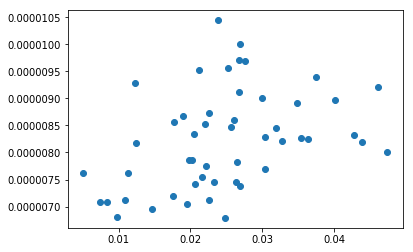

In [7]:
import matplotlib.pyplot as plt

impact_nudges = [item[0] for item in impact_nudges_and_mi] 
mutual_information_sizes = [item[1] for item in impact_nudges_and_mi]
plt.plot(mutual_information_sizes, impact_nudges, 'o')
plt.show()

In [9]:
import scipy
scipy.stats.linregress(impact_nudges, mutual_information_sizes)

LinregressResult(slope=4261.0387134936755, intercept=-0.010378910243526902, rvalue=0.38794161297316965, pvalue=0.0053740431581426329, stderr=1461.202879230319)